In [5]:
import pyro.distributions as dist
from pyro.distributions import TorchDistribution
import pyro
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import Any

# seed = 42
# torch.manual_seed(seed)

### Necessary functions

In [6]:
def PlotDistribution(distribution: pyro.distributions.Distribution, num_samples: int = 1000) -> None:
    """
    Samples from a 2D distribution and visualizes it on a plane.

    Parameters:
    - distribution: A 2D distribution object from torch.distributions.
    - num_samples: The number of samples to visualize (default is 1000).
    """
    samples = distribution.sample((num_samples,))

    samples_np = samples.numpy()

    plt.figure(figsize=(8, 6))
    plt.scatter(samples_np[:, 0], samples_np[:, 1], alpha=0.5)
    plt.title('2D Distribution Sampling')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.show()

### LogisticNormal

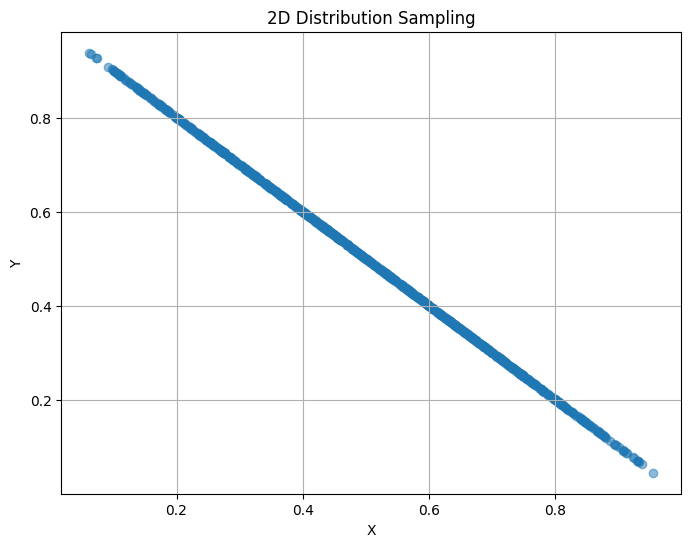

In [7]:
loc = torch.tensor([0.0])
scale = torch.tensor([1.0])
LogisticNormal = dist.LogisticNormal(loc, scale)

PlotDistribution(LogisticNormal)

In [8]:
print(LogisticNormal.rsample())
print(LogisticNormal.sample())

tensor([0.9249, 0.0751])
tensor([0.4778, 0.5222])


### RelaxedBernoulli
- temperature (Tensor) – relaxation temperature

- probs (Number, Tensor) – the probability of sampling 1

- logits (Number, Tensor) – the log-odds of sampling 1

In [9]:
RelaxedBernoulli = dist.RelaxedBernoulli(temperature=torch.tensor([0.01]), probs=torch.tensor([0.1, 0.2, 0.3, 0.99]))

In [10]:
print(RelaxedBernoulli.rsample())
print(RelaxedBernoulli.sample())

tensor([1.1755e-38, 1.1755e-38, 1.0000e+00, 1.0000e+00])
tensor([1.1755e-38, 1.1755e-38, 9.5771e-01, 1.0000e+00])


### [How to add new distribution](https://docs.pyro.ai/en/stable/distributions.html?#torchdistribution)

In [15]:
import torch
from pyro.distributions.torch_distribution import TorchDistribution
from torch.distributions import constraints
from torch.distributions.utils import _standard_normal

class CustomNormal(TorchDistribution):
    """
    Custom Normal distribution class inheriting from Pyro's TorchDistribution.

    Parameters:
    - loc (Tensor): The mean (mu) of the normal distribution.
    - scale (Tensor): The standard deviation (sigma) of the normal distribution.
    """
    
    arg_constraints = {'loc': constraints.real, 'scale': constraints.positive}
    support = constraints.real
    has_rsample = True

    def __init__(self, loc, scale, validate_args=None):
        """
        Initializes the CustomNormal distribution.
        
        Args:
        - loc (Tensor): Mean of the normal distribution.
        - scale (Tensor): Standard deviation of the normal distribution.

        The batch shape is inferred from the shape of the parameters (loc and scale), 
        meaning it defines how many independent distributions are parameterized.
        """
        self.loc = loc
        self.scale = scale
        batch_shape = torch.Size() if loc.dim() == 0 else loc.shape
        super().__init__(batch_shape, validate_args=validate_args)

    @property
    def batch_shape(self):
        """
        Returns the batch shape of the distribution.
        
        The batch shape represents the shape of independent distributions. 
        For example, if `loc` and `scale` are vectors of length 3, 
        the batch shape will be `[3]`, indicating 3 independent normal distributions.
        """
        return self.loc.shape

    @property
    def event_shape(self):
        """
        Returns the event shape of the distribution.
        
        The event shape represents the shape of each individual event. 
        For a standard Normal distribution, each event is a scalar, so `event_shape` is `[]`.
        For a multivariate Normal distribution, for example, the event shape would be the size of the vector.
        """
        return torch.Size()

    def rsample(self, sample_shape=torch.Size()):
        """
        Generates a sample from the distribution using the reparameterization trick.

        Args:
        - sample_shape (torch.Size): The shape of the generated samples.

        Samples are generated by drawing from a standard normal distribution and applying
        the affine transformation `loc + scale * eps` to obtain samples from the desired normal distribution.
        """
        shape = self._extended_shape(sample_shape)
        eps = _standard_normal(shape, dtype=self.loc.dtype, device=self.loc.device)
        return self.loc + self.scale * eps

    def log_prob(self, value):
        """
        Computes the log likelihood of a value under the normal distribution.

        Args:
        - value (Tensor): The value for which to compute the log probability.

        The log probability is calculated using the formula for the normal distribution,
        and it returns a tensor of log probabilities of the same shape as the input.
        """
        var = self.scale ** 2
        log_scale = torch.log(self.scale)
        return -((value - self.loc) ** 2) / (2 * var) - log_scale - 0.5 * torch.log(torch.tensor(2.0 * torch.pi, device=value.device))

In [16]:
loc = torch.tensor([0.0, 5.0])
scale = torch.tensor([1.0, 2.0])

MyNormal = CustomNormal(loc, scale)

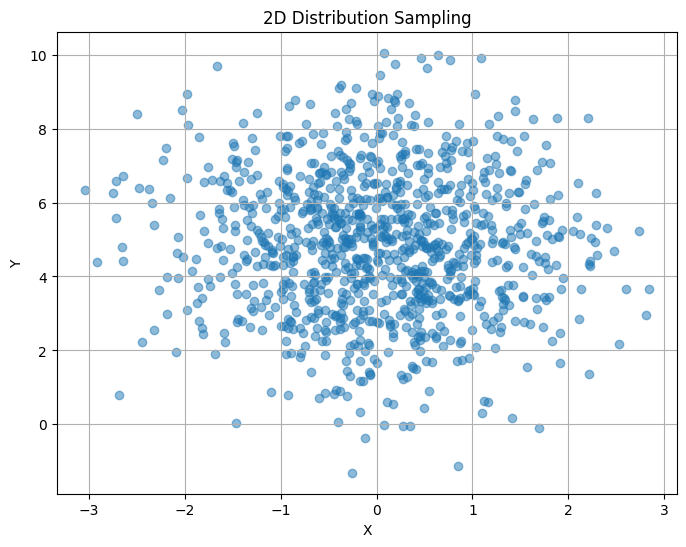

In [17]:
PlotDistribution(MyNormal)